In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import colorsys
import random


In [2]:
def erosion_dilation(img,erosion=True,s=3):
    padding=True
    st = 1
    if padding:
        pad_size = s//2
        img = np.pad(img,(pad_size,pad_size),mode='edge')
    
    h,w = img.shape[0],img.shape[1]
    
    rows = (h - s)//st +1
    cols = (w - s)//st +1
    out = np.zeros((rows,cols))
    
    for i in range(rows):
        for j in range(cols):
            curr = img[i:i+s,j:j+s]
            if erosion:
                out[i,j] = np.min(curr)
            else:
                out[i,j] = np.max(curr)

    return out

def two_pass(img):
    cls = np.zeros(img.shape,dtype=np.int32)
    #1st pass
    neig = []
    c = 0
    if img[0,0]==0:
        cls[0,0] = 0
    else:
        cls[0,0] = 1
        c = 1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i==0:
                if j!=0:
                    if img[i,j]==1 and img[i,j-1]==1:
                        cls[i,j] = cls[i,j-1]
                    elif img[i,j]==1:
                        cls[i,j] = c+1
                        c+=1
            else:
                if img[i,j]==1 and img[i-1,j]==1:
                    cls[i,j] = cls[i-1,j]
                    if j>0 and img[i,j-1]==1:
                        cls[i,j] = np.min(np.array([cls[i-1,j],cls[i,j-1]]))
                        if cls[i-1,j]!=cls[i,j-1]:
                            neig.append(cls[i-1,j])
                            neig.append(cls[i,j-1])
                elif img[i,j]==1 and j>0 and img[i,j-1]==1:
                    cls[i,j] = cls[i,j-1]
                elif img[i,j]==1:
                    cls[i,j] = c+1
                    c+=1
                    
    #calculate the neigbourhood
    arr = np.arange(c+1)
    
    for i in range(len(neig)//2):
        j = min(neig[2*i],neig[2*i+1])
        k = max(neig[2*i],neig[2*i+1])
        arr[k] = j
    
    for i in range(c+1):
        j = arr[i]
        k = i
        while j!=k:
            k = j
            j = arr[j]
        arr[i] = j
    out = cls.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i,j] = arr[cls[i,j]]
    
#     u = np.unique(cls)
    return out,arr

def random_colors(N, bright=True):
    
    brightness = 1.0 if bright else 0.4
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


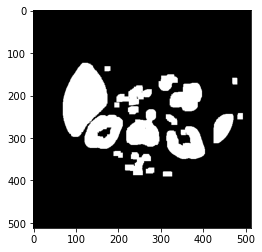

In [3]:
_,img = cv2.threshold(cv2.cvtColor(cv2.imread('../images/kidney.jpg'),cv2.COLOR_BGR2GRAY),128,255,cv2.THRESH_BINARY)
img = img//255
out1 = erosion_dilation(img,erosion=True,s=11)
out1 = erosion_dilation(out1,erosion=False,s=11)
plt.imshow(out1,'gray')
plt.show()

In [4]:
cls,arr = two_pass(out1)
a,c = np.unique(cls,return_counts=True)
c = c[1:]
a = a[1:]
out = out1.copy()

for i in range(a.size):
    if c[i]<300:
        out[cls==a[i]] = 0

new_cls = cls.copy()
for i in range(a.size):
    new_cls[cls==a[i]] = i
    
cols = random_colors(a.size)
final_out = np.zeros((out.shape[0],out.shape[1],3),dtype=np.uint8)

for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        if out[i,j]==0:
            final_out[i,j,:] = 0
        else:
            final_out[i,j,:] = cols[new_cls[i,j]]
            final_out[i,j,:] *= 255

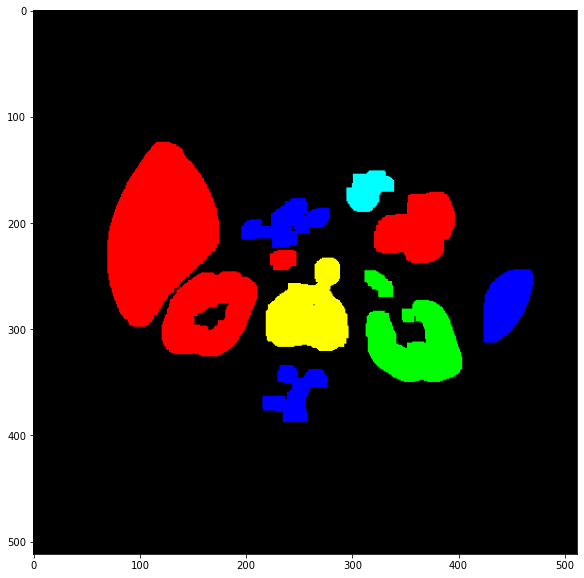

In [5]:
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.imshow(final_out)
plt.show()